In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

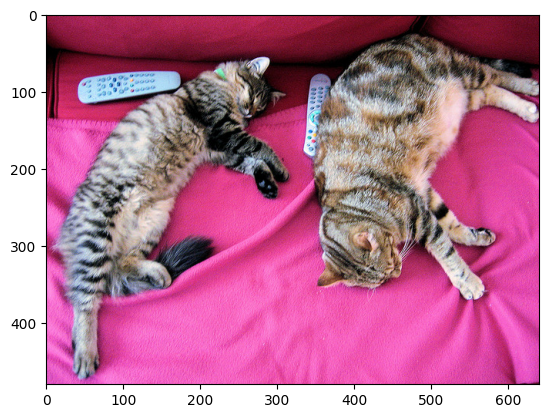

In [3]:
plt.imshow(image)

In [4]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/torch/nn/modules/module.py:2068: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/torch/nn/modules/module.py:2068: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/home/hicham/miniconda3/envs/phd/lib

In [5]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [6]:
def normalize_map(x):
    """Normalize a 2D map to [0,1]."""
    x = x - x.min()
    x = x / (x.max() + 1e-5)
    return x

In [7]:
# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


In [8]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [9]:
outputs.encoder_last_hidden_state[0].shape

torch.Size([850, 256])

In [10]:
features_map = model.model.backbone(**inputs)[0][0][0].numpy()[0]
features_map.shape

(256, 200, 267)

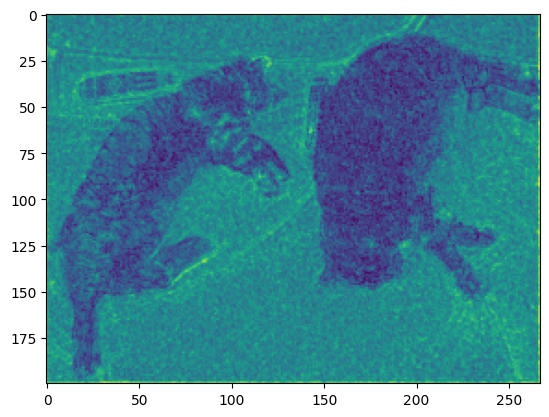

In [11]:
plt.imshow(normalize_map(np.mean(features_map, axis=0)), cmap="viridis")

In [12]:
maps = [normalize_map(features_map[i]) for i in range(features_map.shape[0])]
mean_map = np.stack(maps).mean(0)
mean_map.shape

(200, 267)

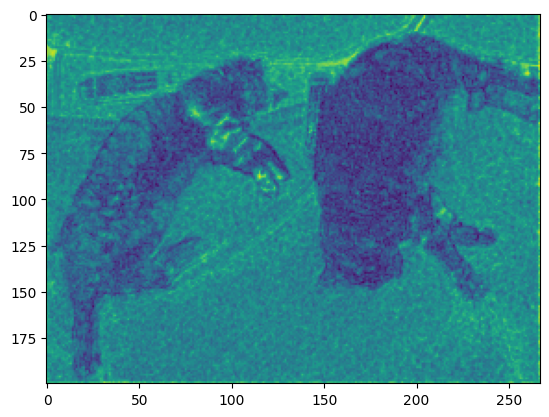

In [13]:
plt.imshow(mean_map, cmap="viridis")